# US-PTO Patent Data Classification on Subclass Level

## Imports and Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from tempfile import TemporaryFile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from __future__ import print_function

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import multi_gpu_model

Using TensorFlow backend.


## System diagnostics

In [2]:
print('Tensorflow version:', tf.__version__)
print('Tensorflow keras version:', tf.keras.__version__)

Tensorflow version: 1.15.0
Tensorflow keras version: 2.2.4-tf


In [3]:
# GPU status
!nvidia-smi

Thu Dec  5 23:22:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    31W / 250W |  15761MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Data ingestion

In [20]:
project_path = ''
path = project_path
all_files = [path + 'data/USPTO-2M/' + f for f in listdir(path + 'data/USPTO-2M') if f.endswith('.json')]
print('Ingesting the following files:\n', sorted(all_files)) #[-2:])
patents = pd.concat(pd.read_json(f) for f in sorted(all_files)) #[-2:])

Ingesting the following files:
 ['data/USPTO-2M/2006_USPTO.json', 'data/USPTO-2M/2007_USPTO.json', 'data/USPTO-2M/2008_USPTO.json', 'data/USPTO-2M/2009_USPTO.json', 'data/USPTO-2M/2010_USPTO.json', 'data/USPTO-2M/2011_USPTO.json', 'data/USPTO-2M/2012_USPTO.json', 'data/USPTO-2M/2013_USPTO.json', 'data/USPTO-2M/2014_USPTO.json', 'data/USPTO-2M/2015_USPTO.json']


## Exploratory Data Analysis

In [21]:
patents.head()

,Abstract,No,Subclass_labels,Title
0,a magnetic disc unit having a rotating disc ty...,US07072141,[G11B],magnetic disc unit with range of gap between d...
1,methods and systems for transforming a volume ...,US06981282,[A41D],systems and methods for transformable suits
2,a gardening glove or the like designed to prev...,US06981283,[A41D],gardening gloves with cushion insert to protec...
3,a hockey helmet for receiving a head of a wear...,US06981284,[A63B],hockey helmet comprising a lateral adjustment ...
4,a toilet and toilet system suitable for a boat...,US06981285,[E03D],toilet and method of operation


In [22]:
print(f"Patents shape: {patents.shape}")

Patents shape: (2000147, 4)


In [23]:
# Find number of unique_words
X = list(patents["Abstract"])
abstract_words = [x for sent in X for x in sent.split(' ')]
unique_words = len(set(abstract_words))
print(f"Total number of words across all abstracts: {len(abstract_words):,}\nNumber of unique words across all abstracts: {unique_words:,}\n")

Total number of words across all abstracts: 218,150,433
Number of unique words across all abstracts: 237,233



## CPC subclass multilabel prediction

In [24]:
# Top 10 CRC codes by count
from collections import Counter
CRC_codes = [(y) for x in patents["Subclass_labels"] for y in x]
result = dict(Counter(CRC_codes))
result_sorted = sorted(result.items(), key=lambda x: x[1])

In [25]:
X = list(patents["Abstract"])
CRC_labels = patents.Subclass_labels
# binarize labels into 1-hot encodings
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(CRC_labels)
num_CRC_labels = len(y[0])
print(f"Total number of CRC labels: {num_CRC_labels}")

Total number of CRC labels: 632


## Remove sparse labels

In [88]:
# identify sparse labels
# sparse_labels = sorted([x[0] for x in result_sorted if x[1] <= 1000 or x[1] > 25000])
sparse_labels = sorted([x[0] for x in result_sorted if x[1] <= 1000])

# remove sparse labels from CRC labels
# freq_CRC_labels = [[label for label in line if label not in sparse_labels] for line in patents.Subclass_labels]

subclass_labels_adj = []
for line in patents['Subclass_labels']:
    lines = []
    for word in line:
        if word not in sparse_labels:
            lines.append(word)
    subclass_labels_adj.append(lines)
patents["Subclass_labels_adj"] = subclass_labels_adj
patents = patents[patents['Subclass_labels_adj'].map(lambda x: len(x)) >0]
# patents.dropna(subset=['Subclass_labels_adj'], inplace = True)

In [89]:
patents.head()

,Abstract,No,Subclass_labels,Title,Subclass_labels_adj
0,a method is presented to address quantitative ...,US08777630,"[A61B, G09B]",method and system for quantitative assessment ...,[A61B]
1,in a method for drilling a borehole real time ...,US08857538,[E21B],method for drilling a borehole,[E21B]
2,a magnetron actuator for moving a magnetron in...,US08900427,"[C23C, H01J]",homing device for magnetron rotating on two arms,"[C23C, H01J]"
3,a method of making a touch sensor assembly com...,US08822833,"[H05K, C23C, G06F]",touch sensor assembly and method of making the...,"[H05K, C23C, G06F]"
4,provided herein are novel epoxide inhibitors o...,US08673904,"[C07D, A61K, A61P]",epoxide inhibitors of cysteine proteases,"[C07D, A61K, A61P]"


In [90]:
patents.shape

(306626, 5)

In [91]:
#X = list(patents["Abstract"])
CRC_labels = patents.Subclass_labels_adj
# binarize labels into 1-hot encodings
mlb = MultiLabelBinarizer()
#y = mlb.fit_transform(CRC_labels)
num_CRC_labels = len(y[0])
print(f"Total number of CRC labels: {num_CRC_labels}")

Total number of CRC labels: 116


## Define training and test set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Embedding vectors using Glove

In [27]:
# Convert to word embeddings

# https://keras.io/preprocessing/text/
tokenizer = Tokenizer(num_words=unique_words)
tokenizer.fit_on_texts(X_train)

# Top 10 words
top10words = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 words:\n", top10words)

# Convert text to sequence of numbers, each number representing a word
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# First 5 of X_train after texts_to_sequences conversion
print("\nX_train:\n", X_train[0])

vocab_size = len(tokenizer.word_index) + 1

maxlen = 250

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# First of X_train after padding
print("\nX_train (after padding):\n", X_train[:1])

Top 10 words:
 [('the', 14764799), ('a', 10909756), ('of', 6290760), ('and', 5380622), ('to', 4590119), ('is', 2869851), ('in', 2638280), ('an', 2349778), ('for', 2064672), ('first', 1312552)]

X_train:
 [20, 1220, 147, 36, 21, 2, 27, 9, 4039, 8, 136, 3, 8, 7663, 39, 162, 2, 101, 15079, 1, 27, 33, 103, 1489, 8, 568, 3, 2, 26093, 5, 2, 1079, 719, 4, 5167, 14, 29, 2, 35, 3, 2, 1807, 381, 5, 1, 1079, 719, 5, 711, 8, 12821, 152, 3861, 7, 20, 12, 56, 4840, 2085, 162, 6240, 3, 8, 7663, 1486]

X_train (after padding):
 [[   20  1220   147    36    21     2    27     9  4039     8   136     3
      8  7663    39   162     2   101 15079     1    27    33   103  1489
      8   568     3     2 26093     5     2  1079   719     4  5167    14
     29     2    35     3     2  1807   381     5     1  1079   719     5
    711     8 12821   152  3861     7    20    12    56  4840  2085   162
   6240     3     8  7663  1486     0     0     0     0     0     0     0
      0     0     0     0     0     0 

In [28]:
# Use GloVe word embeddings to convert text inputs to their numeric counterparts

embeddings_dictionary = dict()

glove_file = open(path + "data/glove/glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Print first item of embedding_matrix
print(f"Embedding Matrix for {tokenizer.sequences_to_texts([[1]])}:\n{embedding_matrix[1:2]}")

Embedding Matrix for ['the']:
[[-0.038194   -0.24487001  0.72812003 -0.39961001  0.083172    0.043953
  -0.39140999  0.3344     -0.57545     0.087459    0.28786999 -0.06731
   0.30906001 -0.26383999 -0.13231    -0.20757     0.33395001 -0.33848
  -0.31742999 -0.48335999  0.1464     -0.37303999  0.34577     0.052041
   0.44946    -0.46970999  0.02628    -0.54154998 -0.15518001 -0.14106999
  -0.039722    0.28277001  0.14393     0.23464    -0.31020999  0.086173
   0.20397     0.52623999  0.17163999 -0.082378   -0.71787    -0.41531
   0.20334999 -0.12763     0.41367     0.55186999  0.57907999 -0.33476999
  -0.36559001 -0.54856998 -0.062892    0.26583999  0.30204999  0.99774998
  -0.80480999 -3.0243001   0.01254    -0.36941999  2.21670008  0.72201002
  -0.24978     0.92136002  0.034514    0.46744999  1.10790002 -0.19358
  -0.074575    0.23353    -0.052062   -0.22044     0.057162   -0.15806
  -0.30798    -0.41624999  0.37972     0.15006    -0.53211999 -0.20550001
  -1.25259995  0.071624    0.

In [14]:
# saves preprocessed BERT_input as pickle
import pickle
with open('glove_outfile.pkl', 'wb') as f:
    pickle.dump(embedding_matrix, f)

In [15]:
# opens preprocessed BERT_input
with open('glove_outfile.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

## Custom loss function

In [17]:
#def custom_cross_entropy(y_true, y_pred):
  #x_ent = y_true * -K.log(y_pred + K.epsilon())
  #return K.sum(x_ent)/K.sum(y_true)

In [18]:
# y_true = tf.constant([0., 1., 1., 1.])
# y_pred = tf.constant([0, 0.9, 1., 1])

In [19]:
# sess = tf.InteractiveSession()
# custom_cross_entropy(y_true, y_pred).eval()

In [20]:
# sess.close()

In [29]:
def weighted_bce(y_true, y_pred):
    # weights become 2 if y_true is 1, and 1 if y_true is 0
    weights = (y_true * 2.) + (1. - y_true)
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

## Custom metrics

In [30]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## CNN - on complete dataset

In [45]:
filters = 512
hidden_dims = 512
print('Build model...')

input = tf.keras.Input(shape=(maxlen,), name='input_embeddings')

embedding = tf.python.keras.layers.Embedding(vocab_size, 100,
                    input_length=maxlen, weights=[embedding_matrix],
                                             trainable=False)(input)

conv0 = tf.keras.layers.Conv1D(filters, 2, activation='relu')(embedding)
maxpool0 = tf.keras.layers.GlobalMaxPooling1D()(conv0)

conv1 = tf.keras.layers.Conv1D(filters, 3, activation='relu')(embedding)
maxpool1 = tf.keras.layers.GlobalMaxPooling1D()(conv1)

conv2 = tf.keras.layers.Conv1D(filters, 4, activation='relu')(embedding)
maxpool2 = tf.keras.layers.GlobalMaxPooling1D()(conv2)

conv3 = tf.keras.layers.Conv1D(filters, 5, activation='relu')(embedding)
maxpool3 = tf.keras.layers.GlobalMaxPooling1D()(conv3)

concat1 = tf.keras.layers.concatenate([maxpool0, maxpool1, maxpool2, maxpool3], axis=1)
dropout1 = tf.keras.layers.Dropout(rate=0.2)(concat1)

dense = tf.keras.layers.Dense(hidden_dims, activation='relu', name='dense')(dropout1)
batchnorm = tf.keras.layers.BatchNormalization()(dense)
dense = tf.keras.layers.Dropout(rate=0.5)(batchnorm)

pred = tf.keras.layers.Dense(num_CRC_labels, activation='sigmoid', name='crc')(dense)

model = tf.keras.models.Model(inputs=input, outputs=pred)

Build model...


In [46]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_embeddings (InputLayer)   [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 250, 100)     21382700    input_embeddings[0][0]           
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 249, 512)     102912      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 248, 512)     154112      embedding_1[0][0]                
____________________________________________________________________________________________

In [47]:
# multi-GPU model
try:
    model = multi_gpu_model(model, gpus=2)
    model.summary()
except:
    pass

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_embeddings (InputLayer)   [(None, 250)]        0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 250)          0           input_embeddings[0][0]           
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 250)          0           input_embeddings[0][0]           
__________________________________________________________________________________________________
model_2 (Model)                 (None, 632)          23476900    lambda_2[0][0]                   
                                                                 lambda_3[0][0]             

In [48]:
model1 = model

In [49]:
metrics=[f1,
         tf.keras.metrics.Precision(name='precision'),
         tf.keras.metrics.Precision(name='precision_1', top_k=1),
         tf.keras.metrics.Recall(name='recall'),
         tf.keras.metrics.Recall(name='recall_5', top_k=5)]

model.compile(loss=weighted_bce,
              optimizer='adam',
              metrics=metrics)

In [50]:
# complete dataset - weighted bce - 512 filters, 512 hidden units
history_complete = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 1600117 samples, validate on 400030 samples
Epoch 1/20
1600117/1600117 [==============================] - 608s 380us/sample - loss: 0.0152 - f1: 0.4207 - precision: 0.2587 - precision_1: 0.4966 - recall: 0.3485 - recall_5: 0.6774 - val_loss: 0.0091 - val_f1: 0.5213 - val_precision: 0.6318 - val_precision_1: 0.5927 - val_recall: 0.4437 - val_recall_5: 0.7774
Epoch 2/20
1600117/1600117 [==============================] - 606s 379us/sample - loss: 0.0098 - f1: 0.4979 - precision: 0.5916 - precision_1: 0.5743 - recall: 0.4301 - recall_5: 0.7544 - val_loss: 0.0086 - val_f1: 0.5366 - val_precision: 0.6554 - val_precision_1: 0.6141 - val_recall: 0.4542 - val_recall_5: 0.7962
Epoch 3/20
1600117/1600117 [==============================] - 605s 378us/sample - loss: 0.0094 - f1: 0.5155 - precision: 0.6021 - precision_1: 0.5923 - recall: 0.4510 - recall_5: 0.7707 - val_loss: 0.0084 - val_f1: 0.5529 - val_precision: 0.6463 - val_precision_1: 0.6264 - val_recall: 0.4831 - val_recall_5: 0.8063

In [51]:
score = model.evaluate(X_test, y_test, verbose=1)
score

400030/400030 [==============================] - 75s 188us/sample - loss: 0.0078 - f1: 0.5861 - precision: 0.6406 - precision_1: 0.6564 - recall: 0.5398 - recall_5: 0.8291


[0.007774359394882077,
 0.58611995,
 0.6405639,
 0.65640074,
 0.5398253,
 0.82909924]

In [54]:
# continue to train for another 20 epochs (=40 in total), weighted bce
history_continue = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 1600117 samples, validate on 400030 samples
Epoch 1/20
1600117/1600117 [==============================] - 644s 403us/sample - loss: 0.0082 - f1: 0.5651 - precision: 0.6254 - precision_1: 0.6463 - recall: 0.5157 - recall_5: 0.8176 - val_loss: 0.0078 - val_f1: 0.5889 - val_precision: 0.6220 - val_precision_1: 0.6581 - val_recall: 0.5590 - val_recall_5: 0.8296
Epoch 2/20
1600117/1600117 [==============================] - 644s 403us/sample - loss: 0.0082 - f1: 0.5657 - precision: 0.6260 - precision_1: 0.6464 - recall: 0.5163 - recall_5: 0.8183 - val_loss: 0.0078 - val_f1: 0.5816 - val_precision: 0.6605 - val_precision_1: 0.6562 - val_recall: 0.5195 - val_recall_5: 0.8289
Epoch 3/20
1600117/1600117 [==============================] - 645s 403us/sample - loss: 0.0082 - f1: 0.5665 - precision: 0.6259 - precision_1: 0.6473 - recall: 0.5178 - recall_5: 0.8193 - val_loss: 0.0077 - val_f1: 0.5864 - val_precision: 0.6459 - val_precision_1: 0.6570 - val_recall: 0.5369 - val_recall_5: 0.8299

In [55]:
model.save(path + "my_keras_model_weighted_bce_40epochs.h5")

In [7]:
from tensorflow.keras.models import load_model
model = load_model('my_keras_model_weighted_bce_40epochs.h5')

ResourceExhaustedError: OOM when allocating tensor with shape[213827,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node embedding_1_1/embeddings/Initializer/random_uniform/RandomUniform (defined at /home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'embedding_1_1/embeddings/Initializer/random_uniform/RandomUniform':
  File "/home/alexmue/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/alexmue/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/alexmue/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/alexmue/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/alexmue/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-33761dc345fa>", line 2, in <module>
    model = load_model('my_keras_model_weighted_bce_40epochs.h5')
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/saving/save.py", line 143, in load_model
    return hdf5_format.load_model_from_hdf5(filepath, custom_objects, compile)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/saving/hdf5_format.py", line 162, in load_model_from_hdf5
    custom_objects=custom_objects)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/saving/model_config.py", line 55, in model_from_config
    return deserialize(config, custom_objects=custom_objects)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/serialization.py", line 105, in deserialize
    printable_module_name='layer')
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/utils/generic_utils.py", line 191, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/network.py", line 1071, in from_config
    process_layer(layer_data)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/network.py", line 1055, in process_layer
    layer = deserialize_layer(layer_data, custom_objects=custom_objects)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/serialization.py", line 105, in deserialize
    printable_module_name='layer')
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/utils/generic_utils.py", line 191, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/network.py", line 1081, in from_config
    process_node(layer, node_data)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/network.py", line 1039, in process_node
    layer(input_tensors, **kwargs)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 824, in __call__
    self._maybe_build(inputs)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 2146, in _maybe_build
    self.build(input_shapes)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/utils/tf_utils.py", line 306, in wrapper
    output_shape = fn(instance, input_shape)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/embeddings.py", line 146, in build
    constraint=self.embeddings_constraint)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 529, in add_weight
    aggregation=aggregation)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py", line 712, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer_utils.py", line 139, in make_variable
    shape=variable_shape if variable_shape else None)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 258, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 219, in _variable_v1_call
    shape=shape)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 197, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variable_scope.py", line 2503, in default_variable_creator
    shape=shape)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 262, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py", line 1406, in __init__
    distribute_strategy=distribute_strategy)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py", line 1537, in _init_from_args
    initial_value() if init_from_fn else initial_value,
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer_utils.py", line 119, in <lambda>
    init_val = lambda: initializer(shape, dtype=dtype)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py", line 283, in __call__
    shape, self.minval, self.maxval, dtype, seed=self.seed)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/random_ops.py", line 245, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_random_ops.py", line 822, in random_uniform
    name=name)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/alexmue/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [56]:
score = model.evaluate(X_test, y_test, verbose=1)
score

400030/400030 [==============================] - 75s 188us/sample - loss: 0.0077 - f1: 0.5923 - precision: 0.6235 - precision_1: 0.6614 - recall: 0.5633 - recall_5: 0.8326


[0.00770692052664675, 0.5922635, 0.6234583, 0.6613954, 0.5633451, 0.8325571]

In [36]:
# complete dataset - bce - 512 filters, 512 hidden units
history_complete = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1600117 samples, validate on 400030 samples
Epoch 1/20
1600117/1600117 [==============================] - 617s 385us/sample - loss: 0.0108 - f1: 0.3542 - precision: 0.2242 - precision_1: 0.4864 - recall: 0.2477 - recall_5: 0.6617 - val_loss: 0.0056 - val_f1: 0.4554 - val_precision: 0.7542 - val_precision_1: 0.5909 - val_recall: 0.3265 - val_recall_5: 0.7736
Epoch 2/20
1600117/1600117 [==============================] - 596s 373us/sample - loss: 0.0060 - f1: 0.4472 - precision: 0.7140 - precision_1: 0.5764 - recall: 0.3259 - recall_5: 0.7516 - val_loss: 0.0053 - val_f1: 0.4911 - val_precision: 0.7548 - val_precision_1: 0.6175 - val_recall: 0.3641 - val_recall_5: 0.7957
Epoch 3/20
1600117/1600117 [==============================] - 597s 373us/sample - loss: 0.0058 - f1: 0.4683 - precision: 0.7244 - precision_1: 0.5961 - recall: 0.3463 - recall_5: 0.7692 - val_loss: 0.0052 - val_f1: 0.4904

In [37]:
score = model.evaluate(X_test, y_test, verbose=1)
score

400030/400030 [==============================] - 69s 172us/sample - loss: 0.0048 - f1: 0.5536 - precision: 0.7475 - precision_1: 0.6600 - recall: 0.4398 - recall_5: 0.8286


[0.004808976752224646, 0.5535554, 0.74747735, 0.659953, 0.4398496, 0.82861596]

In [40]:
# continue to train for another 20 epochs (=40 in total), bce
history_continue = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 1600117 samples, validate on 400030 samples
Epoch 1/20
1600117/1600117 [==============================] - 595s 372us/sample - loss: 0.0050 - f1: 0.5297 - precision: 0.7478 - precision_1: 0.6538 - recall: 0.4106 - recall_5: 0.8165 - val_loss: 0.0048 - val_f1: 0.5587 - val_precision: 0.7411 - val_precision_1: 0.6611 - val_recall: 0.4481 - val_recall_5: 0.8289
Epoch 2/20
1600117/1600117 [==============================] - 595s 372us/sample - loss: 0.0050 - f1: 0.5311 - precision: 0.7485 - precision_1: 0.6552 - recall: 0.4121 - recall_5: 0.8173 - val_loss: 0.0049 - val_f1: 0.5340 - val_precision: 0.7771 - val_precision_1: 0.6612 - val_recall: 0.4063 - val_recall_5: 0.8292
Epoch 3/20
1600117/1600117 [==============================] - 595s 372us/sample - loss: 0.0050 - f1: 0.5320 - precision: 0.7486 - precision_1: 0.6560 - recall: 0.4131 - recall_5: 0.8185 - val_loss: 0.0048 - val_f1: 0.5439 - val_precision: 0.7648 - val_precision_1: 0.6616 - val_recall: 0.4220 - val_recall_5: 0.8292

In [41]:
score = model.evaluate(X_test, y_test, verbose=1)
score

400030/400030 [==============================] - 69s 172us/sample - loss: 0.0048 - f1: 0.5615 - precision: 0.7457 - precision_1: 0.6659 - recall: 0.4505 - recall_5: 0.8323


[0.004761034360711794, 0.5615123, 0.7457495, 0.6659151, 0.4504973, 0.83229023]

In [60]:
# weighted bce - 512 filters, 512 hidden units
history3 = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 282587 samples, validate on 70647 samples
Epoch 1/20
282587/282587 [==============================] - 86s 303us/sample - loss: 0.0374 - f1: 0.3023 - precision: 0.0596 - precision_1: 0.3988 - recall: 0.2347 - recall_5: 0.5159 - val_loss: 0.0137 - val_f1: 0.4451 - val_precision: 0.5467 - val_precision_1: 0.5367 - val_recall: 0.3755 - val_recall_5: 0.6594
Epoch 2/20
282587/282587 [==============================] - 84s 298us/sample - loss: 0.0137 - f1: 0.4321 - precision: 0.5468 - precision_1: 0.5476 - recall: 0.3575 - recall_5: 0.6688 - val_loss: 0.0120 - val_f1: 0.4880 - val_precision: 0.5920 - val_precision_1: 0.5965 - val_recall: 0.4151 - val_recall_5: 0.7138
Epoch 3/20
282587/282587 [==============================] - 84s 298us/sample - loss: 0.0127 - f1: 0.4660 - precision: 0.5628 - precision_1: 0.5840 - recall: 0.3975 - recall_5: 0.7016 - val_loss: 0.0113 - val_f1: 0.5095 - val_precision: 0.6342 - val_precision_1: 0.6228 - val_recall: 0.4257 - val_recall_5: 0.7374
Epoch 4/20

In [61]:
score = model.evaluate(X_test, y_test, verbose=1)
score

70647/70647 [==============================] - 12s 164us/sample - loss: 0.0104 - f1: 0.5615 - precision: 0.6305 - precision_1: 0.6732 - recall: 0.5055 - recall_5: 0.7779


[0.01037125836889274, 0.56149864, 0.6304956, 0.6731638, 0.505483, 0.77789545]

In [54]:
# binary ce - 512 filters, 512 hidden units
history3 = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 282587 samples, validate on 70647 samples
Epoch 1/20
282587/282587 [==============================] - 84s 298us/sample - loss: 0.0310 - f1: 0.2092 - precision: 0.0380 - precision_1: 0.3637 - recall: 0.1403 - recall_5: 0.4749 - val_loss: 0.0085 - val_f1: 0.3616 - val_precision: 0.7037 - val_precision_1: 0.5094 - val_recall: 0.2436 - val_recall_5: 0.6391
Epoch 2/20
282587/282587 [==============================] - 80s 285us/sample - loss: 0.0085 - f1: 0.3634 - precision: 0.6704 - precision_1: 0.5363 - recall: 0.2496 - recall_5: 0.6529 - val_loss: 0.0074 - val_f1: 0.4103 - val_precision: 0.7450 - val_precision_1: 0.5926 - val_recall: 0.2832 - val_recall_5: 0.7043
Epoch 3/20
282587/282587 [==============================] - 80s 284us/sample - loss: 0.0079 - f1: 0.4077 - precision: 0.6840 - precision_1: 0.5812 - recall: 0.2904 - recall_5: 0.6918 - val_loss: 0.0071 - val_f1: 0.4337 - val_precision: 0.7576 - val_precision_1: 0.6178 - val_recall: 0.3037 - val_recall_5: 0.7290
Epoch 4/20

In [55]:
score = model.evaluate(X_test, y_test, verbose=1)
score

70647/70647 [==============================] - 12s 164us/sample - loss: 0.0063 - f1: 0.5269 - precision: 0.7330 - precision_1: 0.6757 - recall: 0.4106 - recall_5: 0.7751


[0.00634031224512466, 0.52692753, 0.73296684, 0.675655, 0.4105992, 0.7751006]

In [49]:
# binary ce - 1024 filters, 256 hidden units
history2 = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 282587 samples, validate on 70647 samples
Epoch 1/20
282587/282587 [==============================] - 147s 519us/sample - loss: 0.0350 - f1: 0.1790 - precision: 0.0315 - precision_1: 0.3376 - recall: 0.1198 - recall_5: 0.4459 - val_loss: 0.0091 - val_f1: 0.2785 - val_precision: 0.7714 - val_precision_1: 0.4763 - val_recall: 0.1701 - val_recall_5: 0.6042
Epoch 2/20
282587/282587 [==============================] - 146s 517us/sample - loss: 0.0091 - f1: 0.3214 - precision: 0.6583 - precision_1: 0.4986 - recall: 0.2129 - recall_5: 0.6193 - val_loss: 0.0079 - val_f1: 0.3915 - val_precision: 0.7226 - val_precision_1: 0.5544 - val_recall: 0.2687 - val_recall_5: 0.6769
Epoch 3/20
282587/282587 [==============================] - 146s 517us/sample - loss: 0.0085 - f1: 0.3644 - precision: 0.6718 - precision_1: 0.5458 - recall: 0.2501 - recall_5: 0.6595 - val_loss: 0.0074 - val_f1: 0.4160 - val_precision: 0.7175 - val_precision_1: 0.5786 - val_recall: 0.2931 - val_recall_5: 0.7056
Epoch 4

In [42]:
# weighted bce - 1024 filters, 256 hidden units
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 282587 samples, validate on 70647 samples
Epoch 1/20
282587/282587 [==============================] - 147s 519us/sample - loss: 0.0417 - f1: 0.2704 - precision: 0.0509 - precision_1: 0.3694 - recall: 0.2038 - recall_5: 0.4862 - val_loss: 0.0143 - val_f1: 0.4065 - val_precision: 0.5647 - val_precision_1: 0.4886 - val_recall: 0.3177 - val_recall_5: 0.6303
Epoch 2/20
282587/282587 [==============================] - 146s 516us/sample - loss: 0.0149 - f1: 0.3915 - precision: 0.5332 - precision_1: 0.5081 - recall: 0.3097 - recall_5: 0.6324 - val_loss: 0.0127 - val_f1: 0.4440 - val_precision: 0.6458 - val_precision_1: 0.5702 - val_recall: 0.3385 - val_recall_5: 0.6922
Epoch 3/20
282587/282587 [==============================] - 147s 519us/sample - loss: 0.0139 - f1: 0.4241 - precision: 0.5496 - precision_1: 0.5461 - recall: 0.3455 - recall_5: 0.6647 - val_loss: 0.0120 - val_f1: 0.4749 - val_precision: 0.6364 - val_precision_1: 0.5944 - val_recall: 0.3790 - val_recall_5: 0.7149
Epoch 4

In [70]:
# only with cca. 200 labels and 0.8M dataset
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 642652 samples, validate on 160664 samples
Epoch 1/20
642652/642652 [==============================] - 124s 193us/sample - loss: 0.0281 - f1: 0.3999 - precision: 0.3306 - precision_1: 0.5367 - precision_5: 0.1969 - recall: 0.2921 - recall_1: 0.3923 - recall_5: 0.7194 - val_loss: 0.0174 - val_f1: 0.4932 - val_precision: 0.7266 - val_precision_1: 0.6227 - val_precision_5: 0.2185 - val_recall: 0.3735 - val_recall_1: 0.4543 - val_recall_5: 0.7970
Epoch 2/20
642652/642652 [==============================] - 123s 191us/sample - loss: 0.0173 - f1: 0.4978 - precision: 0.7231 - precision_1: 0.6254 - precision_5: 0.2198 - recall: 0.3799 - recall_1: 0.4571 - recall_5: 0.8033 - val_loss: 0.0162 - val_f1: 0.5286 - val_precision: 0.7408 - val_precision_1: 0.6514 - val_precision_5: 0.2253 - val_recall: 0.4109 - val_recall_1: 0.4752 - val_recall_5: 0.8219
Epoch 3/20
642652/642652 [==============================] - 123s 191us/sample - loss: 0.0164 - f1: 0.5227 - precision: 0.7361 - precision_1:

In [56]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          validation_data=(X_test, y_test))

Train on 688084 samples, validate on 172022 samples
Epoch 1/5
688084/688084 [==============================] - 135s 196us/sample - loss: 0.0072 - f1: 0.6280 - precision: 0.6601 - precision_1: 0.7239 - precision_5: 0.2441 - recall: 0.5990 - recall_1: 0.5096 - recall_5: 0.8592 - val_loss: 0.0088 - val_f1: 0.5835 - val_precision: 0.5939 - val_precision_1: 0.6694 - val_precision_5: 0.2300 - val_recall: 0.5727 - val_recall_1: 0.4714 - val_recall_5: 0.8099
Epoch 2/5
688084/688084 [==============================] - 134s 195us/sample - loss: 0.0071 - f1: 0.6282 - precision: 0.6590 - precision_1: 0.7234 - precision_5: 0.2447 - recall: 0.6003 - recall_1: 0.5093 - recall_5: 0.8614 - val_loss: 0.0088 - val_f1: 0.5840 - val_precision: 0.5964 - val_precision_1: 0.6699 - val_precision_5: 0.2300 - val_recall: 0.5717 - val_recall_1: 0.4718 - val_recall_5: 0.8100
Epoch 3/5
688084/688084 [==============================] - 134s 195us/sample - loss: 0.0071 - f1: 0.6288 - precision: 0.6580 - precision_1: 0.

In [50]:
istory = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 688084 samples, validate on 172022 samples
Epoch 1/20
688084/688084 [==============================] - 135s 196us/sample - loss: 0.0134 - f1: 0.3583 - precision: 0.1712 - precision_1: 0.4967 - precision_5: 0.1851 - recall: 0.2530 - recall_1: 0.3497 - recall_5: 0.6515 - val_loss: 0.0063 - val_f1: 0.4712 - val_precision: 0.7009 - val_precision_1: 0.5927 - val_precision_5: 0.2120 - val_recall: 0.3550 - val_recall_1: 0.4174 - val_recall_5: 0.7467
Epoch 2/20
688084/688084 [==============================] - 134s 194us/sample - loss: 0.0063 - f1: 0.4608 - precision: 0.7099 - precision_1: 0.5976 - precision_5: 0.2134 - recall: 0.3414 - recall_1: 0.4207 - recall_5: 0.7511 - val_loss: 0.0059 - val_f1: 0.4990 - val_precision: 0.7239 - val_precision_1: 0.6250 - val_precision_5: 0.2203 - val_recall: 0.3808 - val_recall_1: 0.4402 - val_recall_5: 0.7757
Epoch 3/20
688084/688084 [==============================] - 134s 194us/sample - loss: 0.0059 - f1: 0.4885 - precision: 0.7249 - precision_1:

In [45]:
history = model.fit(X_train, y_train,
          batch_size=512,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 688084 samples, validate on 172022 samples
Epoch 1/20
688084/688084 [==============================] - 117s 170us/sample - loss: 0.0457 - f1: 0.1249 - precision: 0.0127 - precision_1: 0.2634 - precision_5: 0.1103 - recall: 0.0895 - recall_1: 0.1854 - recall_5: 0.3882 - val_loss: 0.0087 - val_f1: 0.2558 - val_precision: 0.7008 - val_precision_1: 0.3965 - val_precision_5: 0.1615 - val_recall: 0.1565 - val_recall_1: 0.2792 - val_recall_5: 0.5687
Epoch 2/20
688084/688084 [==============================] - 116s 168us/sample - loss: 0.0084 - f1: 0.2951 - precision: 0.6635 - precision_1: 0.4424 - precision_5: 0.1737 - recall: 0.1905 - recall_1: 0.3115 - recall_5: 0.6114 - val_loss: 0.0070 - val_f1: 0.3904 - val_precision: 0.7228 - val_precision_1: 0.5281 - val_precision_5: 0.1970 - val_recall: 0.2675 - val_recall_1: 0.3719 - val_recall_5: 0.6936
Epoch 3/20
688084/688084 [==============================] - 115s 168us/sample - loss: 0.0075 - f1: 0.3648 - precision: 0.6822 - precision_1:

In [34]:
history = model.fit(X_train, y_train,
          batch_size=256,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 688084 samples, validate on 172022 samples
Epoch 1/20
688084/688084 [==============================] - 82s 119us/sample - loss: 0.0345 - f1: 0.1115 - precision: 0.0162 - precision_1: 0.2568 - precision_5: 0.1086 - recall: 0.0750 - recall_1: 0.1808 - recall_5: 0.3824 - val_loss: 0.0086 - val_f1: 0.2394 - val_precision: 0.7234 - val_precision_1: 0.3978 - val_precision_5: 0.1633 - val_recall: 0.1435 - val_recall_1: 0.2802 - val_recall_5: 0.5750
Epoch 2/20
688084/688084 [==============================] - 68s 99us/sample - loss: 0.0086 - f1: 0.2761 - precision: 0.6576 - precision_1: 0.4261 - precision_5: 0.1692 - recall: 0.1754 - recall_1: 0.2999 - recall_5: 0.5957 - val_loss: 0.0071 - val_f1: 0.3311 - val_precision: 0.7798 - val_precision_1: 0.5151 - val_precision_5: 0.1939 - val_recall: 0.2102 - val_recall_1: 0.3627 - val_recall_5: 0.6827
Epoch 3/20
688084/688084 [==============================] - 68s 99us/sample - loss: 0.0077 - f1: 0.3342 - precision: 0.6831 - precision_1: 0.48

In [36]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(X_test, y_test))

Train on 688084 samples, validate on 172022 samples
Epoch 1/20
688084/688084 [==============================] - 131s 190us/sample - loss: 0.0061 - f1: 0.4797 - precision: 0.7414 - precision_1: 0.6106 - precision_5: 0.2150 - recall: 0.3545 - recall_1: 0.4298 - recall_5: 0.7570 - val_loss: 0.0058 - val_f1: 0.4910 - val_precision: 0.7521 - val_precision_1: 0.6224 - val_precision_5: 0.2192 - val_recall: 0.3645 - val_recall_1: 0.4384 - val_recall_5: 0.7718
Epoch 2/20
688084/688084 [==============================] - 130s 189us/sample - loss: 0.0059 - f1: 0.4952 - precision: 0.7507 - precision_1: 0.6269 - precision_5: 0.2187 - recall: 0.3694 - recall_1: 0.4413 - recall_5: 0.7699 - val_loss: 0.0057 - val_f1: 0.5035 - val_precision: 0.7547 - val_precision_1: 0.6323 - val_precision_5: 0.2209 - val_recall: 0.3778 - val_recall_1: 0.4453 - val_recall_5: 0.7779
Epoch 3/20
688084/688084 [==============================] - 130s 189us/sample - loss: 0.0057 - f1: 0.5043 - precision: 0.7550 - precision_1:

In [34]:
test = model.predict(X_train, batch_size=128)

## Look at specific examples

In [36]:
no = 6
# get indices of largest probabilities
test[no].argsort()[-3:][::-1]

array([ 77,  88, 108])

In [37]:
# get largest probabilities
test[no][test[1].argsort()[-3:][::-1]]

array([9.2189294e-01, 2.9802322e-08, 0.0000000e+00], dtype=float32)

In [38]:
# see if predictions match ground truth labels
y_test[no][test[no].argsort()[-3:][::-1]]

array([1, 0, 0])

In [39]:
# get indices of ground truth with highest probabilities
y_test[no].argsort()[-3:][::-1]

array([ 77, 115,  41])

In [40]:
# see ground truth labels
y_test[no][y_test[no].argsort()[-3:][::-1]]

array([1, 0, 0])

In [41]:
# check predicted probabilities of correct labels
test[no][y_test[no].argsort()[-3:][::-1]]

array([0.92189294, 0.        , 0.        ], dtype=float32)

## Store model

In [42]:
model.save(path + "my_keras_model_bce_40epochs.h5")

## Model evaluation

In [43]:
score = model.evaluate(X_test, y_test, verbose=1)
score

70647/70647 [==============================] - 15s 207us/sample - loss: 0.0109 - f1: 0.5359 - precision: 0.6581 - precision_1: 0.6571 - recall: 0.4517 - recall_5: 0.7631


[0.010908965775946538, 0.5358963, 0.6581036, 0.6570697, 0.45171255, 0.76311994]

In [57]:
def plot_metric(hist, metrics, title):
  for metric in metrics:
    metric_to_plot = hist[metric]
    plt.plot(metric_to_plot, label=metric)
  plt.title(title)
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("metric")

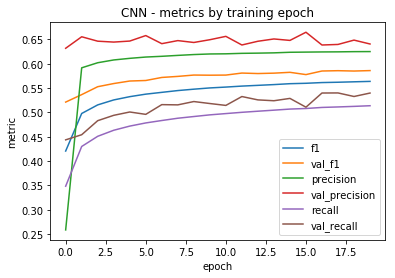

In [53]:
# weighted bce, complete dataset, 20 epochs
plot_metric(history_complete.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

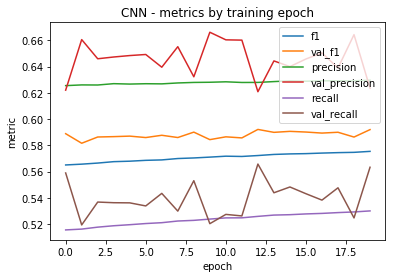

In [58]:
# weighted bce, complete dataset, epochs 20-40
plot_metric(history_continue.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

In [66]:
def add_dictionaries(dict1, dict2):
    new_dict = {}
    for key, value in dict1.items():
        new_dict[key] = value
    for key, value in dict2.items():
        if key in new_dict:
            new_dict[key] += value
        else:
            new_dict[key] += value
    return new_dict


history_all = add_dictionaries(history_complete.history, history_continue.history)

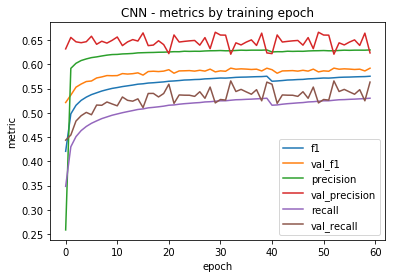

In [65]:
plot_metric(history_all, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

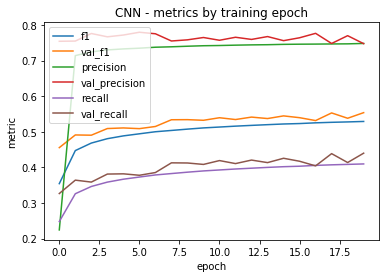

In [44]:
# bce, complete dataset, 20-40 epochs
plot_metric(history_complete.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

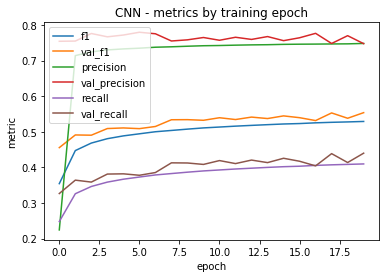

In [39]:
# bce, complete dataset, first 20 epochs
plot_metric(history_complete.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

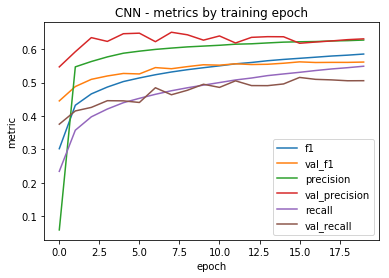

In [65]:
plot_metric(history3.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

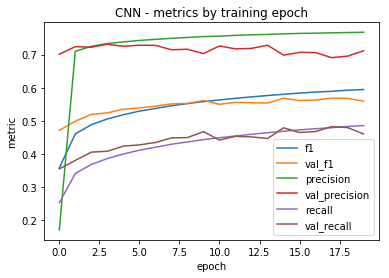

In [55]:
plot_metric(istory.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

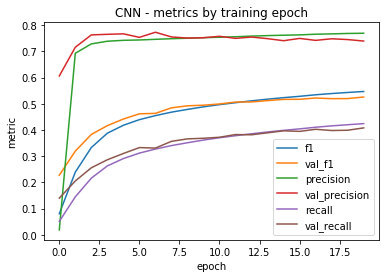

In [33]:
plot_metric(history.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

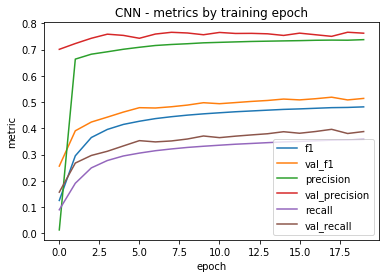

In [46]:
plot_metric(history.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

In [ ]:
plot_metric(history.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

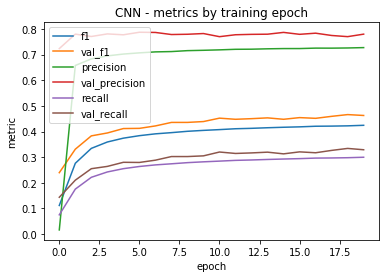

In [36]:
plot_metric(history.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

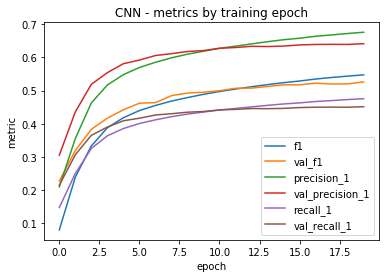

In [34]:
plot_metric(history.history, ["f1", "val_f1", "precision_1", "val_precision_1", 
                             "recall_1", "val_recall_1"], "CNN - metrics by training epoch")

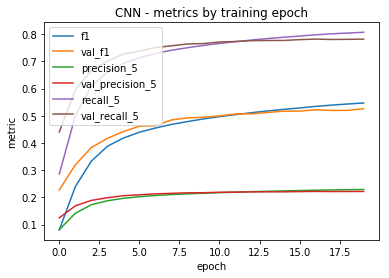

In [35]:
plot_metric(history.history, ["f1", "val_f1", "precision_5", "val_precision_5", 
                             "recall_5", "val_recall_5"], "CNN - metrics by training epoch")

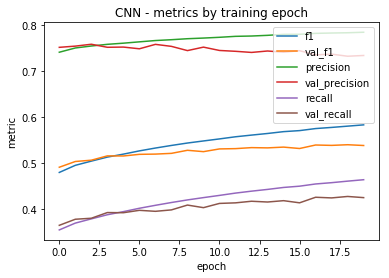

In [37]:
plot_metric(history.history, ["f1", "val_f1", "precision", "val_precision", 
                             "recall", "val_recall"], "CNN - metrics by training epoch")

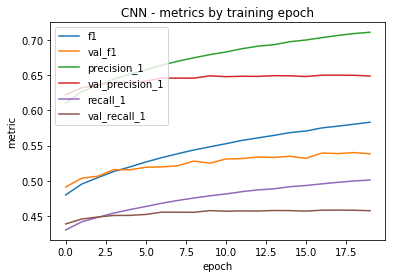

In [38]:
plot_metric(history.history, ["f1", "val_f1", "precision_1", "val_precision_1", 
                             "recall_1", "val_recall_1"], "CNN - metrics by training epoch")

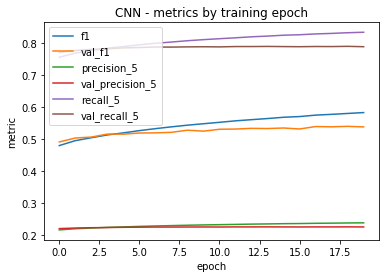

In [39]:
plot_metric(history.history, ["f1", "val_f1", "precision_5", "val_precision_5", 
                             "recall_5", "val_recall_5"], "CNN - metrics by training epoch")

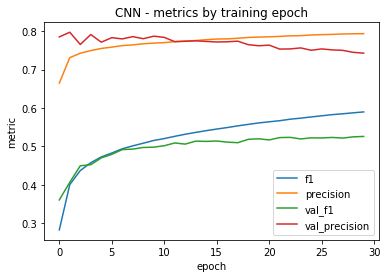

In [54]:
plot_metric(history.history, ["f1", "precision", "val_f1", "val_precision"], "CNN - metrics by training epoch")

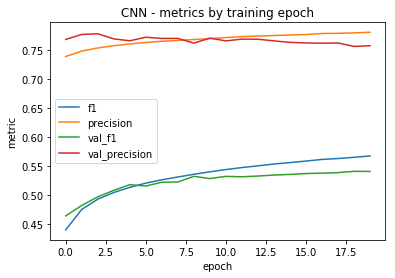

In [31]:
plot_metric(history.history, ["f1", "precision", "val_f1", "val_precision"], "CNN - metrics by training epoch")

## Model with custom loss function

In [46]:
model1.compile(loss=weighted_bce,
              optimizer='adam',
              metrics=[f1, precision, 'accuracy'])

In [47]:
history1 = model1.fit(X_train, y_train,
          batch_size=128,
          epochs=30,
          validation_data=(X_test, y_test))

Train on 245300 samples, validate on 61326 samples
Epoch 1/10
245300/245300 [==============================] - 22s 91us/sample - loss: 0.0230 - f1: 0.7555 - precision: 0.7487 - acc: 0.7037 - val_loss: 0.0633 - val_f1: 0.5686 - val_precision: 0.5904 - val_acc: 0.5284
Epoch 2/10
245300/245300 [==============================] - 22s 89us/sample - loss: 0.0224 - f1: 0.7588 - precision: 0.7460 - acc: 0.7057 - val_loss: 0.0650 - val_f1: 0.5671 - val_precision: 0.5885 - val_acc: 0.5253
Epoch 3/10
245300/245300 [==============================] - 22s 89us/sample - loss: 0.0220 - f1: 0.7624 - precision: 0.7470 - acc: 0.7059 - val_loss: 0.0671 - val_f1: 0.5646 - val_precision: 0.5955 - val_acc: 0.5255
Epoch 4/10
245300/245300 [==============================] - 22s 89us/sample - loss: 0.0217 - f1: 0.7652 - precision: 0.7478 - acc: 0.7095 - val_loss: 0.0667 - val_f1: 0.5659 - val_precision: 0.5875 - val_acc: 0.5236
Epoch 5/10
245300/245300 [==============================] - 22s 89us/sample - loss: 0

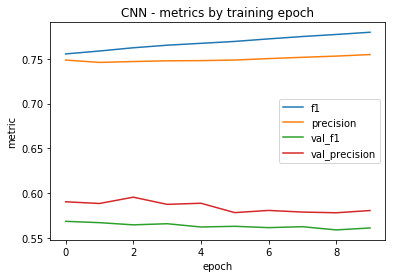

In [48]:
plot_metric(history1.history, ["f1", "precision", "val_f1", "val_precision"], "CNN - metrics by training epoch")

In [143]:
test1 = model1.predict(X_train, batch_size=128)

In [195]:
#test1[6]

In [149]:
# get indices of largest probabilities
test1[6].argsort()[-3:][::-1]

array([88, 77, 93])

In [150]:
# get largest probabilities
test1[6][test1[6].argsort()[-3:][::-1]]

array([0.75569373, 0.37112147, 0.11726686], dtype=float32)

In [151]:
y_test[6][test1[6].argsort()[-3:][::-1]]

array([0, 1, 0])

## Metric: Top K Categorical Accuracy

In [185]:
from keras.metrics import top_k_categorical_accuracy
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[top_k_categorical_accuracy])

In [186]:
history1 = model1.fit(X_train, y_train,
          batch_size=128,
          epochs=3,
          validation_data=(X_test, y_test))

Train on 245300 samples, validate on 61326 samples
Epoch 1/3
245300/245300 [==============================] - 12s 47us/sample - loss: 0.0261 - top_k_categorical_accuracy: 0.8780 - val_loss: 0.0261 - val_top_k_categorical_accuracy: 0.8768
Epoch 2/3
245300/245300 [==============================] - 11s 46us/sample - loss: 0.0260 - top_k_categorical_accuracy: 0.8785 - val_loss: 0.0261 - val_top_k_categorical_accuracy: 0.8783
Epoch 3/3
245300/245300 [==============================] - 11s 46us/sample - loss: 0.0259 - top_k_categorical_accuracy: 0.8789 - val_loss: 0.0261 - val_top_k_categorical_accuracy: 0.8774


In [177]:
test1 = model1.predict(X_train, batch_size=128)

In [178]:
# get indices of largest probabilities
test1[6].argsort()[-3:][::-1]

array([ 88,  77, 104])

In [197]:
test1[6][test1[6].argsort()[-3:][::-1]]

array([0.79584527, 0.5847361 , 0.04956934], dtype=float32)

## Metric: Top K precision, recall

TOP 5: F1, Precision, Recall
- Deep Patent 45   35    74
- PatentBERT 46,85 32,19 86
- us          NA   22    77

TOP 1: F1, Precision, Recall
- Deep Patent  NA,  73,88  
- PatentBERT 64,91 80,61 54,33
- us            NA    62    43

In [44]:
metrics=[tf.keras.metrics.Precision(name='precision_1', top_k=1),
         tf.keras.metrics.Precision(name='precision_5', top_k=5),
         tf.keras.metrics.Recall(name='recall_1', top_k=1),
         tf.keras.metrics.Recall(name='recall_5', top_k=5),
         'accuracy']

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)

In [45]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(X_test, y_test))

Train on 688084 samples, validate on 172022 samples
Epoch 1/10
688084/688084 [==============================] - 68s 98us/sample - loss: 0.0112 - precision_1: 0.3942 - precision_5: 0.1548 - recall_1: 0.2775 - recall_5: 0.5448 - acc: 0.9973 - val_loss: 0.0072 - val_precision_1: 0.5099 - val_precision_5: 0.1911 - val_recall_1: 0.3591 - val_recall_5: 0.6728 - val_acc: 0.9981
Epoch 2/10
688084/688084 [==============================] - 67s 97us/sample - loss: 0.0070 - precision_1: 0.5296 - precision_5: 0.1959 - recall_1: 0.3729 - recall_5: 0.6896 - acc: 0.9981 - val_loss: 0.0067 - val_precision_1: 0.5619 - val_precision_5: 0.2056 - val_recall_1: 0.3957 - val_recall_5: 0.7241 - val_acc: 0.9982
Epoch 3/10
688084/688084 [==============================] - 67s 97us/sample - loss: 0.0066 - precision_1: 0.5667 - precision_5: 0.2050 - recall_1: 0.3989 - recall_5: 0.7216 - acc: 0.9982 - val_loss: 0.0063 - val_precision_1: 0.5860 - val_precision_5: 0.2106 - val_recall_1: 0.4127 - val_recall_5: 0.7417 

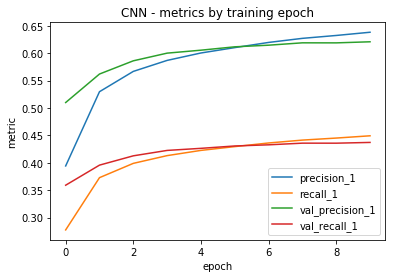

In [46]:
# on full label set
plot_metric(history.history, ["precision_1", "recall_1", "val_precision_1", "val_recall_1"], "CNN - metrics by training epoch")

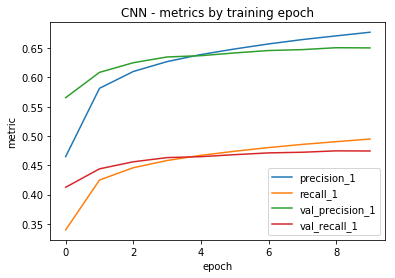

In [28]:
# on reduced label set
plot_metric(history.history, ["precision_1", "recall_1", "val_precision_1", "val_recall_1"], "CNN - metrics by training epoch")

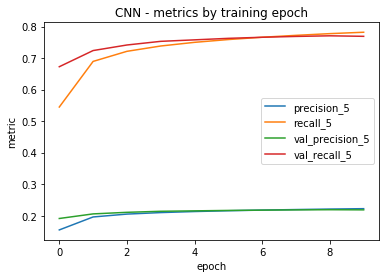

In [47]:
# on full label set
plot_metric(history.history, ["precision_5", "recall_5", "val_precision_5", "val_recall_5"], "CNN - metrics by training epoch")

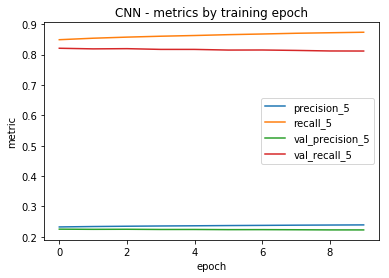

In [31]:
# on reduced label set (reducing labels helps for top5-analysis, but not for top-1)
plot_metric(history.history, ["precision_5", "recall_5", "val_precision_5", "val_recall_5"], "CNN - metrics by training epoch")

## Top K Precision / Recall with custom loss function

In [49]:
metrics=[tf.keras.metrics.Precision(name='precision_1', top_k=1),
         tf.keras.metrics.Precision(name='precision_5', top_k=5),
         tf.keras.metrics.Recall(name='recall_1', top_k=1),
         tf.keras.metrics.Recall(name='recall_5', top_k=5),
         'accuracy']

model.compile(loss=weighted_bce,
              optimizer='adam',
              metrics=metrics)

In [50]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(X_test, y_test))

Train on 688084 samples, validate on 172022 samples
Epoch 1/10
688084/688084 [==============================] - 68s 99us/sample - loss: 0.0090 - precision_1: 0.6413 - precision_5: 0.2233 - recall_1: 0.4515 - recall_5: 0.7859 - acc: 0.5357 - val_loss: 0.0097 - val_precision_1: 0.6204 - val_precision_5: 0.2191 - val_recall_1: 0.4369 - val_recall_5: 0.7717 - val_acc: 0.5216
Epoch 2/10
688084/688084 [==============================] - 67s 97us/sample - loss: 0.0089 - precision_1: 0.6444 - precision_5: 0.2246 - recall_1: 0.4537 - recall_5: 0.7905 - acc: 0.5382 - val_loss: 0.0096 - val_precision_1: 0.6201 - val_precision_5: 0.2189 - val_recall_1: 0.4367 - val_recall_5: 0.7710 - val_acc: 0.5202
Epoch 3/10
688084/688084 [==============================] - 67s 97us/sample - loss: 0.0088 - precision_1: 0.6480 - precision_5: 0.2255 - recall_1: 0.4562 - recall_5: 0.7939 - acc: 0.5408 - val_loss: 0.0097 - val_precision_1: 0.6203 - val_precision_5: 0.2191 - val_recall_1: 0.4369 - val_recall_5: 0.7715 

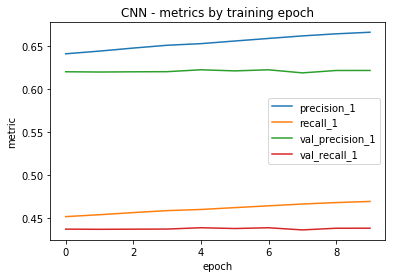

In [52]:
# on full label set
plot_metric(history.history, ["precision_1", "recall_1", "val_precision_1", "val_recall_1"], "CNN - metrics by training epoch")

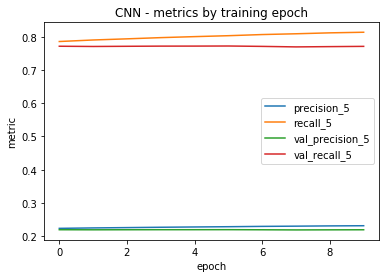

In [54]:
# on full label set
plot_metric(history.history, ["precision_5", "recall_5", "val_precision_5", "val_recall_5"], "CNN - metrics by training epoch")

## Cluster analysis

In [187]:
CRC_clusters = [','.join(x) for x in patents["Subclass_labels_adj"]]

In [189]:
counters = Counter(CRC_clusters)
counters.most_common(100)

[('G06F', 35161),
 ('H01L', 18825),
 ('H04N', 7364),
 ('H04L', 6861),
 ('A61B', 6742),
 ('H04W', 5249),
 ('G06F,H04L', 4901),
 ('A61K', 4741),
 ('G06K', 4272),
 ('G06Q', 4129),
 ('H04B', 3973),
 ('G01N', 3433),
 ('G11C', 3176),
 ('G03G', 3110),
 ('G02B', 2964),
 ('B41J', 2961),
 ('A61F', 2878),
 ('H01M', 2839),
 ('H04M', 2503),
 ('B65D', 2479),
 ('A61M', 2373),
 ('G09G', 2325),
 ('C07D,A61K', 2282),
 ('E21B', 2202),
 ('G11B', 2183),
 ('H01R', 2041),
 ('G01R', 1836),
 ('B01D', 1819),
 ('A63B', 1765),
 ('A61N', 1747),
 ('H05K', 1726),
 ('H04L,H04W', 1708),
 ('F21V', 1654),
 ('C07C', 1539),
 ('A01H', 1511),
 ('H05B', 1503),
 ('B29C', 1499),
 ('G06F,G06Q', 1487),
 ('G02F', 1448),
 ('B32B', 1377),
 ('H03K', 1313),
 ('G06F,H04N', 1301),
 ('B60R', 1300),
 ('B62D', 1262),
 ('F16H', 1261),
 ('H04R', 1259),
 ('G08B', 1201),
 ('H03M', 1201),
 ('H01J', 1199),
 ('C07D', 1185),
 ('A63F', 1181),
 ('H01Q', 1122),
 ('F01D', 1117),
 ('H04B,H04W', 1093),
 ('C07K,A61K', 1082),
 ('E04B', 1069),
 ('H02K', 1

In [194]:
counters.most_common()[:-100:-1]

[('G09G,G03B,H01S,H04N', 1),
 ('C12N,C02F,B01J,C12P', 1),
 ('G06K,G01N,H01J', 1),
 ('C07H,C12P,C12Q,C07K', 1),
 ('C07H,G06F,C12P,C12Q,C12N', 1),
 ('G02B,C08F,C08K,C09D,G03F', 1),
 ('H05K,C08L,H01L,G03F,C08F,H01B', 1),
 ('C09K,G03G', 1),
 ('C01B,B32B,B82Y,C23C', 1),
 ('B32B,H04M,G02B', 1),
 ('B32B,B23K,B01D,C23C', 1),
 ('B32B,C04B,H01L,B82Y', 1),
 ('B29C,B32B,C08L,C08J', 1),
 ('H01L,C08K,C09D,H01B', 1),
 ('B32B,C08K,B82Y,C09D', 1),
 ('C23C,C08K,C09D', 1),
 ('C04B,B32B,E04B', 1),
 ('B32B,B82Y,C23C', 1),
 ('C09K,G02B,G02F,C08L,C08J', 1),
 ('H05K,C23C,B05D,C08J', 1),
 ('B32B,B23K,F01D,C23C,B23P', 1),
 ('C08L,C08G,B05D,C08J', 1),
 ('C01B,C09K,B05D', 1),
 ('C23C,C04B,H01L,B05D', 1),
 ('A61M,A61K,C07D,C07F', 1),
 ('B82Y,C01B,B01J,C04B', 1),
 ('H05B,B01J,C07C,C07D', 1),
 ('B29C,B01J,C08J,B01D', 1),
 ('C01B,A61L,A01N', 1),
 ('B32B,B82Y,C01B,H01M,C04B', 1),
 ('A61K,C01B,A01N,B01J', 1),
 ('F21V,H01J,C23C', 1),
 ('H05B,H01L,C08K,C09D', 1),
 ('H05K,G03F,C09K', 1),
 ('C08L,C08K,C08J,C08G,E04B', 1),
